In [1]:
import numpy as np
import pandas as pd
import os
import os.path as osp
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy
import time
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
import torch.utils.data as data
from torch.cuda.amp import autocast, GradScaler
import torchvision
from torchvision import models, transforms
import timm

from bi_tempered_loss_pytorch import bi_tempered_logistic_loss
from temperature_scaling import ModelWithTemperature

# package_path = osp.join('..','input','image-fmix','FMix-master')
# import sys; sys.path.append(package_path)
# from fmix import sample_mask

In [2]:
config = {
    'rootpath': osp.join('..','input','cassava-leaf-disease-classification'),
    'seed': 334,
    'num_folds': 5,
    
    # augmentaion params
    'aug': {
        'ver': 'V3',
        'size': 512,
#         'size': 384,
#         'size': 224,
        'mean': (0.485, 0.456, 0.406),
        'std': (0.229, 0.224, 0.225),
#         'degrees': 45,
        'degrees': 90,
        'brightness': 0.3,
        'contrast': 0.3,
    },
    
    'do_mix': False,
    'do_TemperatureScaling': False,
    'freezeBN': False,
    
    # loss params
    'loss': {
#         'name': 'CrossEntropyLoss',
        'name': 'BiTemperedLogisticLoss',
        't1': 0.2,
        't2': 1.2,
#         't2': 4.0,
#         'label_smoothing': 0.01,
        'label_smoothing': 0.05,
        'num_iters': 5,
        'reduction': 'mean'
    },

#     'model_name': 'resnet50',
#     'model_name': 'resnext50_32x4d',
#     'model_name': 'seresnext50_32x4d',
    'model_name': 'tf_efficientnet_b4_ns',
    'batch_size': 8,
    'test_batch_size': 1,
    'num_epochs': 10,
    'set_all': True,
    
    # optim params
    'optim': {
#         'name': 'SGD',
        'name': 'Adam',
        'lr': 1e-04,
        'T_0': 10,   # CosineAnnealingWarmRestarts
        'T_mult': 1,   # CosineAnnealingWarmRestarts
        'min_lr': 1e-06,   # CosineAnnealingWarmRestarts
        'last_epoch': -1,   # CosineAnnealingWarmRestarts
        'weight_decay': 1e-06
    }
}


In [3]:
train = pd.read_csv(osp.join(config['rootpath'], 'train.csv'))
train['image_path'] = osp.join(config['rootpath'], 'train_images')
train['image_path'] = train['image_path'].str.cat(train['image_id'], sep=osp.sep)
train.head()

,image_id,label,image_path
0,1000015157.jpg,0,..\input\cassava-leaf-disease-classification\t...
1,1000201771.jpg,3,..\input\cassava-leaf-disease-classification\t...
2,100042118.jpg,1,..\input\cassava-leaf-disease-classification\t...
3,1000723321.jpg,1,..\input\cassava-leaf-disease-classification\t...
4,1000812911.jpg,3,..\input\cassava-leaf-disease-classification\t...


In [4]:
# submission = pd.read_csv(osp.join(config['rootpath'], 'sample_submission.csv'))
# submission.head()

# Preprocessing Class

In [5]:
class ImageTransform():
    def __init__(self, resize, mean, std, degrees=45, brightness=0.3, contrast=0.3):
        self.data_transform = {
            'V1': {
                'train': transforms.Compose([
                    transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                ]),
                'val': transforms.Compose([
                    transforms.Resize(resize),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                ]),
                'test': transforms.Compose([
                    transforms.Resize(resize),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                ])                
            },
            'V2': {
                'train': transforms.Compose([
                    transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(degrees),
                    transforms.ColorJitter(brightness, contrast),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                ]),
                'val': transforms.Compose([
                    transforms.Resize(resize),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                ]),
                'test': transforms.Compose([
                    transforms.Resize(resize),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                ])
            },
            'V3': {
                'train': transforms.Compose([
                    transforms.RandomResizedCrop(resize),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(degrees),
                    transforms.ColorJitter(brightness, contrast),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                ]),
                'val': transforms.Compose([
                    transforms.Resize(resize),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                ]),
                'test': transforms.Compose([
                    transforms.Resize(resize),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                ])
            }
        }

    def __call__(self, img, ver='V1', phase='train'):
        return self.data_transform[ver][phase](img)


# Dataset Class

In [6]:
class CassavaDataset(data.Dataset):
    def __init__(self, filepath2label, transform=None, ver='V1', phase='train', output_label=True):
        self.file_list = list(filepath2label.keys())
        self.transform = transform
        self.filepath2label = filepath2label
        self.ver = ver
        self.phase = phase
        self.output_label = output_label
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img, self.ver, self.phase)
        if self.output_label:
            label = self.filepath2label[img_path]
            return img, label
        else:
            return img        

In [7]:
# # 動作確認

# index = 0
# print(train_dataset.__getitem__(index)[0].size())

# DataLoader

In [8]:
def get_DataLoader(dataset, batch_size, shuffle=True):
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle, pin_memory=True)

In [9]:
# # 動作確認

# batch_iterator = iter(dataloaders_dict['train'])
# inputs, labels = next(batch_iterator)
# print(inputs.size())
# print(labels)

# Make Network model

## ResNext50_32x4d

In [10]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, 5, bias=True)

    def forward(self, x):
        x = self.model(x)
        return x

## EfficientNet (b4)

In [11]:
class CustomEfficientNet(nn.Module):
    def __init__(self, model_name='tf_efficientnet_b4_ns', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, 5)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

## Get Network

In [12]:
def get_network(model_name, use_pretrained=True):
    if model_name == 'vgg19':
        net = models.vgg19(pretrained=use_pretrained)
        net.classifier[6] = nn.Linear(in_features=4096, out_features=5, bias=True)
        update_param_names = ['classifier.6.weight', 'classifier.6.bias']
    elif model_name == 'resnet50':
        net = models.resnet50(pretrained=use_pretrained)
        net.fc = nn.Linear(in_features=2048, out_features=5, bias=True)
        update_param_names = ['fc.weight', 'fc.bias']
    elif model_name == 'resnext50_32x4d':
        net = CustomResNext(model_name=model_name, pretrained=use_pretrained)
        update_param_names = ['model.fc.weight', 'model.fc.bias']
    elif model_name == 'seresnext50_32x4d':
        net = CustomResNext(model_name=model_name, pretrained=use_pretrained)
        update_param_names = ['model.fc.weight', 'model.fc.bias']
    elif model_name == 'tf_efficientnet_b4_ns':
        net = CustomEfficientNet(model_name=model_name, pretrained=use_pretrained)
        update_param_names = ['model.classifier.weight', 'model.classifier.bias']
    
    return net, update_param_names


# Define Loss function

In [13]:
class BiTemperedLogisticLoss(nn.Module):
    def __init__(self, t1=0.8, t2=1.4, label_smoothing=0.0, num_iters=5, reduction='mean'):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.label_smoothing = label_smoothing
        self.num_iters = num_iters
        self.reduction = reduction

    def forward(self, outputs, labels):
        loss = bi_tempered_logistic_loss(outputs, labels, t1=self.t1, t2=self.t2, label_smoothing=self.label_smoothing, num_iters=self.num_iters, reduction=self.reduction)
        return loss

In [14]:
def get_criterion(loss, params):
    if loss == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    elif loss == 'BiTemperedLogisticLoss':
        criterion = BiTemperedLogisticLoss(params['t1'], params['t2'], params['label_smoothing'], params['num_iters'], params['reduction'])
    return criterion

# Set Optimization

In [15]:
def set_params(net, update_param_names, set_all=False):
    # add parameters to learn by fine-tuning to params_to_update
    params_to_update = []

    for name, param in net.named_parameters():
        if set_all:
            if config['freezeBN'] and (name.find('bn') != -1):
                param.requires_grad = False
            else:
                param.requires_grad = True
                params_to_update.append(param)
        else:
            if name in update_param_names:
                if config['freezeBN'] and (name.find('bn') != -1):
                    param.requires_grad = False
                else:
                    param.requires_grad = True
                    params_to_update.append(param)
            else:
                param.requires_grad = False

#     print("-----------------")
#     print(params_to_update)
    
    return params_to_update

In [16]:
def get_optimizer(optimizer_name, params_to_update):
    # set optimizer
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(params=params_to_update, lr=config['optim']['lr'], momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(params=params_to_update, lr=config['optim']['lr'], weight_decay=config['optim']['weight_decay'])
    
    return optimizer

## Scheduler

In [17]:
def get_scheduler(optimizer):
#     if CFG.scheduler=='ReduceLROnPlateau':
#         scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
#     elif CFG.scheduler=='CosineAnnealingLR':
#         scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
#     elif CFG.scheduler=='CosineAnnealingWarmRestarts':
#         scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=config['optim']['T_0'], T_mult=config['optim']['T_mult'], eta_min=config['optim']['min_lr'], last_epoch=config['optim']['last_epoch'])
    return scheduler

# Cutmix & Fmix

In [18]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.3,0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets

def fmix(data, targets, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    #mask =torch.tensor(mask, device=device).float()
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    x1 = torch.from_numpy(mask).to(device)*data
    x2 = torch.from_numpy(1-mask).to(device)*shuffled_data
    targets=(targets, shuffled_targets, lam)
    
    return (x1+x2), targets

# Train & Validation

In [19]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs, sheduler, device):
    # move network to device
    net.to(device)
    
    # try speeding up
    torch.backends.cudnn.benchmark = True
    
    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0
    best_valid_preds = np.array([])
    best_valid_labels = np.array([])
    
    # LOOP: epoch
    epoch_result_dict = {'train': {'loss': np.array([]), 'acc': np.array([])}, 'val': {'loss': np.array([]), 'acc': np.array([])}}
    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('--------------------')
        
        # LOOP: train & valid at each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()   # set train mode
            else:
                net.eval()   # set validation mode
            
            epoch_loss = 0.0   # sum of epoch loss
            epoch_corrects = 0   # number of epoch correctness
            
            epoch_valid_preds = np.array([])
            epoch_valid_labels = np.array([])
            
            # training at epoch = 0 is omitted to confirm the verification performance when unlearned.
#             if (epoch == 0) and (phase == 'train'):
#                 continue
            
            # LOOP: mini-batch
            for inputs, labels in dataloaders_dict[phase]:
                # move inputs, labels to device
                inputs = inputs.to(device).float()
                labels = labels.to(device).long()
                
                if phase == 'train' and config['do_mix']:
                    mix_decision = np.random.rand()
                    if mix_decision < 0.25:
                        inputs, labels = cutmix(inputs, labels, 1.)
                    elif mix_decision >=0.25 and mix_decision < 0.5:
                        inputs, labels = fmix(inputs, labels, alpha=1., decay_power=5., shape=(config['aug']['size'], config['aug']['size']))
                    
                # initialize optimizer
                optimizer.zero_grad()
                
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    with autocast():
                        outputs = net(inputs.float())
                        
                        if phase == 'train':
                            if config['do_mix'] and mix_decision < 0.50:
                                loss = criterion(outputs, labels[0]) * labels[2] + criterion(outputs, labels[1]) * (1. - labels[2])
                            else:
                                loss = criterion(outputs, labels)
                        else:
                            loss = criterion(outputs, labels)
                            
#                         loss = criterion(outputs, labels)   # calc loss
                        _, preds = torch.max(outputs, 1)   # get predicted label

                        # when train, run back propagation
                        if phase == 'train':
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()
                            # loss.backward()
                            # optimizer.step()

                        # calc iteration result
                        epoch_loss += loss.item() * inputs.size(0)
                        if phase == 'train' and config['do_mix'] and mix_decision < 0.5:
                            epoch_corrects += torch.sum(preds == labels[0].data).item()
                        else:
                            epoch_corrects += torch.sum(preds == labels.data).item()
                            
                        if phase == 'val':
                            epoch_valid_preds = np.append(epoch_valid_preds, preds.cpu().numpy())
                            epoch_valid_labels = np.append(epoch_valid_labels, labels.data.cpu().numpy())

                    
            # scheduler
#             if isinstance(scheduler, ReduceLROnPlateau):
#                 scheduler.step(avg_val_loss)
#             elif isinstance(scheduler, CosineAnnealingLR):
#                 scheduler.step()
#             elif isinstance(scheduler, CosineAnnealingWarmRestarts):
#                 scheduler.step()
            scheduler.step()
            
            # print loss & accuracy in each epoch
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = float(epoch_corrects) / len(dataloaders_dict[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            epoch_result_dict[phase]['loss'] = np.append(epoch_result_dict[phase]['loss'], epoch_loss)
            epoch_result_dict[phase]['acc'] = np.append(epoch_result_dict[phase]['acc'], epoch_acc)

            if phase == 'val':
                # plot current epoch result
                plt.plot(range(len(epoch_result_dict['train']['loss'])), epoch_result_dict['train']['loss'], label='train loss', linewidth=2, marker='D')
                plt.plot(range(len(epoch_result_dict['val']['loss'])), epoch_result_dict['val']['loss'], label='valid loss', linewidth=2, marker='D')
                plt.xlabel('epoch')
                plt.ylabel('loss')
                plt.legend()
                plt.show()

                # plot train & val ACC (each epoch)
                plt.plot(range(len(epoch_result_dict['train']['acc'])), epoch_result_dict['train']['acc'], label='train acc', linewidth=2, marker='D')
                plt.plot(range(len(epoch_result_dict['val']['acc'])), epoch_result_dict['val']['acc'], label='valid acc', linewidth=2, marker='D')
                plt.xlabel('epoch')
                plt.ylabel('acc')
                plt.legend()
                plt.show()
            
            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(net.state_dict())
                
                best_valid_preds = copy.copy(epoch_valid_preds)
                best_valid_labels = copy.copy(epoch_valid_labels)

    net.load_state_dict(best_model_wts)
    
    # save valid preds & labels
    valid_result = pd.DataFrame({"pred": best_valid_preds, "label": best_valid_labels})
    
    return net, epoch_result_dict, valid_result

# Inference

In [20]:
def inference_test_data(net, dataloader, device):
    all_preds = np.array([], dtype=int)
    net.eval()
    for inputs in tqdm(dataloader):
        inputs = inputs.to(device).float()
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)   # get predicted label
        preds = preds.detach().cpu().numpy()
        all_preds = np.append(all_preds, preds)
    return all_preds

# Utils

In [21]:
def set_random_seed(seed):
    # set random seed
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [22]:
def make_datapath_list(rootpath, phase='train'):
    target_path = osp.join(rootpath, phase+'_images', '*.jpg')

    path_list = []
    for path in glob.glob(target_path):
        path_list.append(path)
    return path_list

In [23]:
def make_filename_info(title, ext, model_name, fold, aug_ver, loss_name, num_epochs, batch_size, size, set_all, lr, do_mix, freezeBN):
    if loss_name == 'CrossEntropyLoss':
        filename = title+'_'+model_name+'_fold'+str(fold)+'_'+aug_ver+'_loss'+loss_name+'_epoch'+str(num_epochs)+'_batchsize'+str(batch_size)+'_imgsize'+str(size)+'_allparams'+str(set_all)+'_lr'+str(lr)+'_Mix'+str(do_mix)+'_freezeBN'+str(freezeBN)+ext
    elif loss_name == 'BiTemperedLogisticLoss':
        filename = title+'_'+model_name+'_fold'+str(fold)+'_'+aug_ver+'_loss'+loss_name+'_t1'+str(config['loss']['t1'])+'_t2'+str(config['loss']['t2'])+'_labelsmoothing'+str(config['loss']['label_smoothing'])+'_epoch'+str(num_epochs)+'_batchsize'+str(batch_size)+'_imgsize'+str(size)+'_allparams'+str(set_all)+'_lr'+str(lr)+'_Mix'+str(do_mix)+'_freezeBN'+str(freezeBN)+ext
    return filename

# main

0it [00:00, ?it/s]

use device:  cuda:0



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch 1/10
--------------------
train Loss: 0.1609 Acc: 0.7924
val Loss: 0.1175 Acc: 0.8500


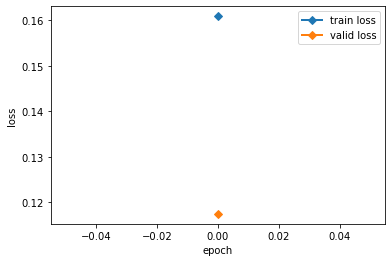

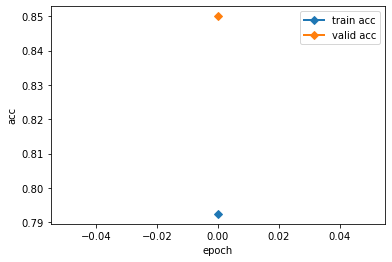


 10%|████████                                                                        | 1/10 [16:10<2:25:36, 970.67s/it]

Epoch 2/10
--------------------
train Loss: 0.1221 Acc: 0.8485
val Loss: 0.1010 Acc: 0.8724


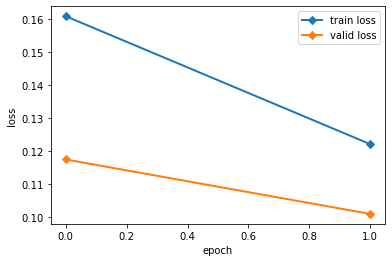

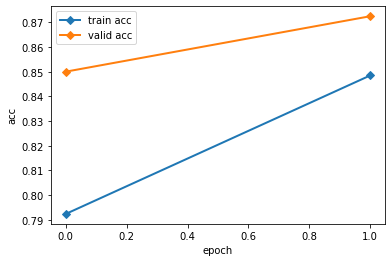


 20%|████████████████                                                                | 2/10 [32:14<2:09:08, 968.60s/it]

Epoch 3/10
--------------------
train Loss: 0.1096 Acc: 0.8645
val Loss: 0.0902 Acc: 0.8881


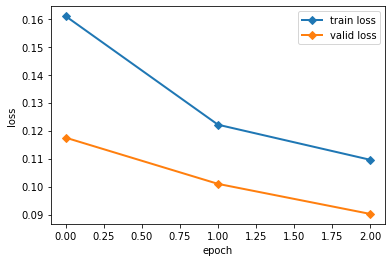

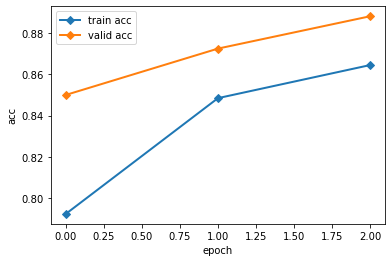


 30%|████████████████████████                                                        | 3/10 [48:17<1:52:48, 966.98s/it]

Epoch 4/10
--------------------
train Loss: 0.0995 Acc: 0.8771
val Loss: 0.0892 Acc: 0.8867


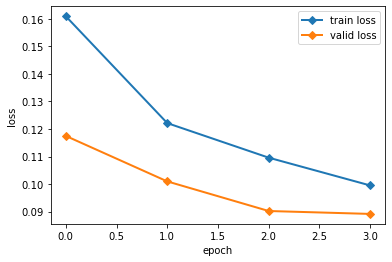

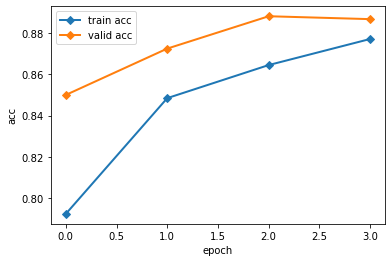


 40%|███████████████████████████████▏                                              | 4/10 [1:04:21<1:36:36, 966.07s/it]

Epoch 5/10
--------------------
train Loss: 0.0928 Acc: 0.8853
val Loss: 0.0860 Acc: 0.8925


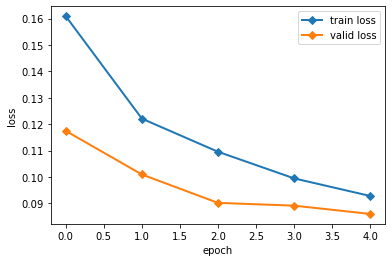

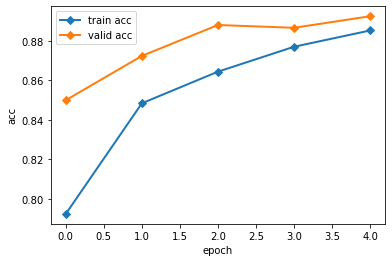


 50%|███████████████████████████████████████                                       | 5/10 [1:20:25<1:20:27, 965.48s/it]

Epoch 6/10
--------------------
train Loss: 0.1078 Acc: 0.8652
val Loss: 0.0961 Acc: 0.8806


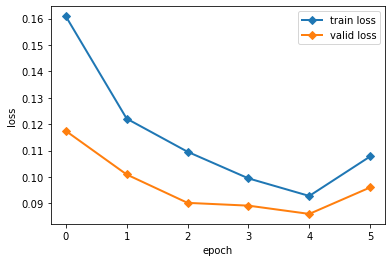

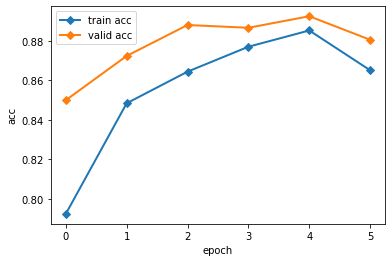


 60%|██████████████████████████████████████████████▊                               | 6/10 [1:36:30<1:04:20, 965.16s/it]

Epoch 7/10
--------------------
train Loss: 0.1014 Acc: 0.8738
val Loss: 0.0892 Acc: 0.8881


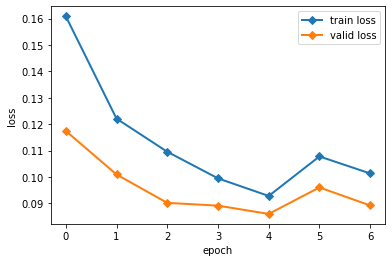

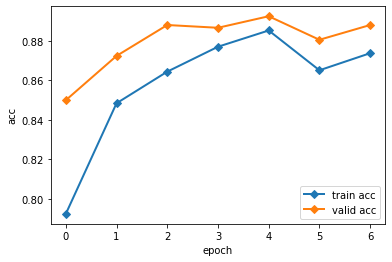


 70%|████████████████████████████████████████████████████████                        | 7/10 [1:52:34<48:14, 964.94s/it]

Epoch 8/10
--------------------
train Loss: 0.0983 Acc: 0.8775
val Loss: 0.0961 Acc: 0.8808


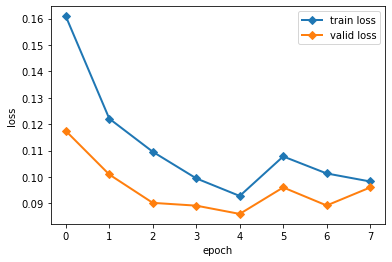

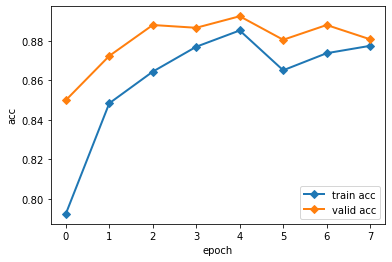


 80%|████████████████████████████████████████████████████████████████                | 8/10 [2:08:40<32:10, 965.37s/it]

Epoch 9/10
--------------------
train Loss: 0.0904 Acc: 0.8891
val Loss: 0.0878 Acc: 0.8956


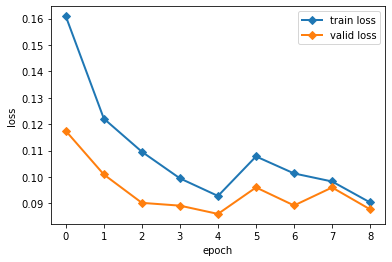

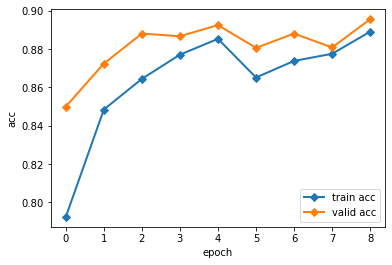


 90%|████████████████████████████████████████████████████████████████████████        | 9/10 [2:24:46<16:05, 965.35s/it]

Epoch 10/10
--------------------
train Loss: 0.0837 Acc: 0.8967
val Loss: 0.0899 Acc: 0.8890


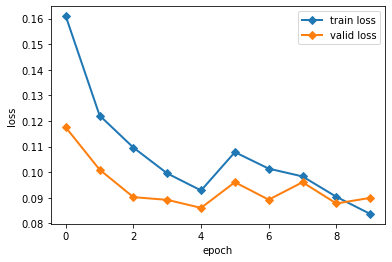

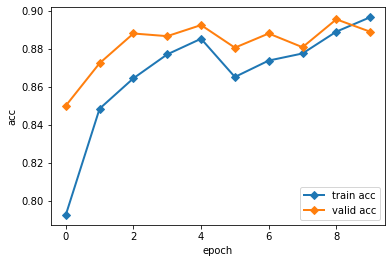


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [2:40:52<00:00, 965.20s/it]

Fold0 Running time:9653.643958091736[sec]


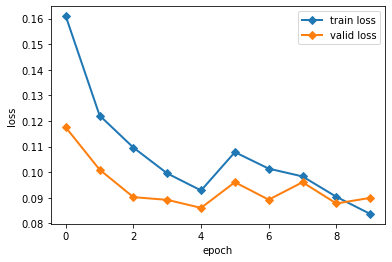

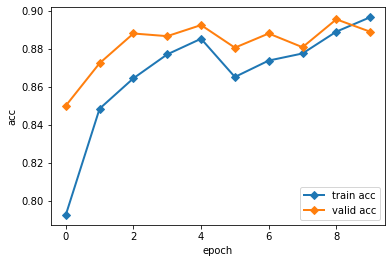

1it [2:40:54, 9654.15s/it]


In [24]:
if __name__ == "__main__":
    set_random_seed(config['seed'])
    
    # device setting
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("use device: ", device)

    # CV loop
    folds = StratifiedKFold(n_splits=config['num_folds'], shuffle=True, random_state=config['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    for fold, (train_idx, val_idx) in tqdm(enumerate(folds)):
        time_start = time.time()
#         if fold > 0:
#             break
        
        # Dataset
        train_filepath2label = dict(zip(train.loc[train_idx, :].image_path, train.loc[train_idx, :].label))
        val_filepath2label = dict(zip(train.loc[val_idx, :].image_path, train.loc[val_idx, :].label))

        train_dataset = CassavaDataset(train_filepath2label, ImageTransform(config['aug']['size'], config['aug']['mean'], config['aug']['std'], config['aug']['degrees'], config['aug']['brightness'], config['aug']['brightness']), config['aug']['ver'], 'train', True)
        val_dataset = CassavaDataset(val_filepath2label, ImageTransform(config['aug']['size'], config['aug']['mean'], config['aug']['std'], config['aug']['degrees'], config['aug']['brightness'], config['aug']['brightness']), config['aug']['ver'], 'val', True)
        
        # DataLoader
        train_dataloader = get_DataLoader(train_dataset, config['batch_size'], True)
        val_dataloader = get_DataLoader(val_dataset, config['batch_size'], True)
        dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}
        
        # get NetWork model
        use_pretrained = True
        net, update_param_names = get_network(config['model_name'], use_pretrained)
        
        # set train mode
        net.train()
        
        # GradScaler
        scaler = GradScaler() 

        # criterion
        criterion = get_criterion(config['loss']['name'], config['loss'])

        # get optimizer
        params_to_update = set_params(net, update_param_names, config['set_all'])
        optimizer = get_optimizer(config['optim']['name'], params_to_update)
        
        # scheduler
        scheduler = get_scheduler(optimizer)
        
        # train & valid
        net, epoch_result_dict, valid_result = train_model(net, dataloaders_dict, criterion, optimizer, config['num_epochs'], scheduler, device)
        
        elapsed_time = time.time() - time_start
        print("Fold{} Running time:{}".format(fold, elapsed_time) + "[sec]")
        
        # plot train & val loss (each epoch)
        figname = make_filename_info('loss', '.png', config['model_name'], fold, config['aug']['ver'], config['loss']['name'], config['num_epochs'], config['batch_size'], config['aug']['size'], config['set_all'], config['optim']['lr'], config['do_mix'], config['freezeBN'])
        plt.plot(range(len(epoch_result_dict['train']['loss'])), epoch_result_dict['train']['loss'], label='train loss', linewidth=2, marker='D')
        plt.plot(range(len(epoch_result_dict['val']['loss'])), epoch_result_dict['val']['loss'], label='valid loss', linewidth=2, marker='D')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.savefig(osp.join('fig', figname))
        plt.show()

        # plot train & val ACC (each epoch)
        figname = make_filename_info('acc', '.png', config['model_name'], fold, config['aug']['ver'], config['loss']['name'], config['num_epochs'], config['batch_size'], config['aug']['size'], config['set_all'], config['optim']['lr'], config['do_mix'], config['freezeBN'])
        plt.plot(range(len(epoch_result_dict['train']['acc'])), epoch_result_dict['train']['acc'], label='train acc', linewidth=2, marker='D')
        plt.plot(range(len(epoch_result_dict['val']['acc'])), epoch_result_dict['val']['acc'], label='valid acc', linewidth=2, marker='D')
        plt.xlabel('epoch')
        plt.ylabel('acc')
        plt.legend()
        plt.savefig(osp.join('fig', figname))
        plt.show()

        # save model
        filename = make_filename_info('model', '.pth', config['model_name'], fold, config['aug']['ver'], config['loss']['name'], config['num_epochs'], config['batch_size'], config['aug']['size'], config['set_all'], config['optim']['lr'], config['do_mix'], config['freezeBN'])
        save_path = osp.join('trained_model', filename)
        torch.save(net.state_dict(), save_path)
        
        # TemperatureScaling
        if config['do_TemperatureScaling']:
            net = ModelWithTemperature(net)
            net.set_temperature(dataloaders_dict['val'])

            # save model
            filename = 'TemperatureScaling_' + filename
            save_path = osp.join('trained_model', filename)
            torch.save(scaled_model.model.state_dict(), save_path)
            
        # save valid preds
        filename = make_filename_info('validpreds', '.csv', config['model_name'], fold, config['aug']['ver'], config['loss']['name'], config['num_epochs'], config['batch_size'], config['aug']['size'], config['set_all'], config['optim']['lr'], config['do_mix'], config['freezeBN'])
        save_path = osp.join('valid_preds', filename)
        valid_result.to_csv(save_path, index=False)

#     # prediction for test dataset
#     test_datalist = make_datapath_list(config['rootpath'], 'test')
#     test_filepath2label = dict(zip(test_datalist, [0] * len(test_datalist)))
#     test_dataset = CassavaDataset(test_filepath2label, ImageTransform(config['aug']['size'], config['aug']['mean'], config['aug']['std'], config['aug']['degrees'], config['aug']['brightness'], config['aug']['brightness']), config['aug']['ver'], 'test', False)
#     test_dataloader = get_DataLoader(test_dataset, config['batch_size'], False)
    
#     test_preds = inference_test_data(net, test_dataloader, device)
    
#     # make submission.csv
#     submission = pd.DataFrame({'image_id': [osp.basename(k) for k in test_datalist], 'label': test_preds})
#     submission.to_csv('submission.csv', index=False)